In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import pandas as pd
from tabulate import tabulate

In [88]:
def p_st(mu_s, covar_s, covar_ts, A, AT, t):
    

    mu_sT = mu_s[:,None]
    covar_st = np.linalg.inv(np.linalg.inv(covar_s) + (AT * (1/covar_ts) * A))
    mu_st = covar_st @ (np.linalg.inv(covar_s) @ mu_sT + AT * (1/covar_ts) *t)
    return stats.multivariate_normal.rvs(np.ravel(mu_st), covar_st)

# Truncated
def p_ts(y, s1, s2, covar_s, covar_ts, A, AT):
    
    # Player 1 wins
    if y == 1:
        ing1 = 0
        ing2 = np.Inf
        
    # Player 2 wins
    else:
        ing1 = -np.Inf
        ing2 = 0
    
    mu_t = s1 - s2
    sigma_t  = np.sqrt(covar_ts +A @ covar_s @ AT)
    #sigma_t = 25/3
    return stats.truncnorm.rvs((ing1 - mu_t) / sigma_t, (ing2 - mu_t) / sigma_t, loc=mu_t, scale=sigma_t)

def p_s(mu, sigma, x):
    
    return stats.norm.pdf(x, mu, sigma)
    #return 1 / (np.sqrt(2*np.pi*co))*np.exp(-(x-m)**2/2/co)


In [86]:
def gibbs(K, mu_s, cov_s, cov_ts, t0, burn_in=0, y=1):
    
    A = np.array([1, -1])
    AT = A[:,None]
    
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    
    s1[0] = mu_s[0] 
    s2[0] = mu_s[1]
    t[0] = t0

    for k in range(K - 1):
        
        s1[k+1], s2[k+1] = p_st(mu_s, covar_s, covar_ts, A, AT, t[k])
        t[k+1] = p_ts(y, s1[k+1], s2[k+1], covar_s, covar_ts, A, AT)
        
    return s1[burn_in::], s2[burn_in::], t[burn_in::]

In [15]:
def trueskillGaussDist(X, s1, s2):
    
    #plt.plot(X, p_s(m_s1, var_s1, X), label="p(s1)", linestyle="dashed", color="red")
    plt.plot(X, p_s(m_s2, var_s2, X), label="p(s1) and p(s2)", linestyle="dashed", color="orange")
    plt.plot(X, p_s(np.mean(s1), np.std(s1), X), label="p(s1|y=1)", color="blue")
    plt.plot(X, p_s(np.mean(s2),np.std(s2), X), label="p(s2|y=1)", color="purple")
    plt.legend()
    plt.show()

In [17]:
Klist = [250, 500, 750, 1000, 2500, 5000]
#Klist = [700, 750, 800, 850]
burn_in = 150
def sss(Kl, mu_s, covar_s, covar_ts, t0, burn_in):
    
    xx = np.linspace(0, 50, 1000)
    for k in Kl:
        t_start = time.perf_counter()
        s1, s2, t = gibbs(k+burn_in, mu_s, covar_s, covar_ts, t0, burn_in)
        t_stop = time.perf_counter()
        plt.plot(xx, p_s(np.mean(s1), np.std(s1), xx), label="S1 post", color="red")
        plt.hist(s1,bins=30, density=True)
        plt.title("K = {}, time = {:.2f}".format(k, (t_stop - t_start)))
        plt.show()
        


In [23]:
def dataPreprocesser(df):
    
    # Create a new column for the result and filter the draws
    df['result'] = np.sign(df["score1"] - df["score2"])
    df = df.loc[df['result'] != 0]
    
    df2 = pd.DataFrame()
    df2["club"] = df["team1"].unique()
    df2["win"], df2["loss"], df2["mean"], df2["variance"] = 0, 0, 25, 25/3
    
    for i, row in df.iterrows():
        if row["result"] == 1:
            df2.loc[df2["club"] == row["team1"], "win"] += 1
            df2.loc[df2["club"] == row["team2"], "loss"] += 1
        elif row["result"] == -1:
            df2.loc[df2["club"] == row["team2"], "win"] += 1
            df2.loc[df2["club"] == row["team1"], "loss"] += 1
        else:
            print("Dataframe contains draws.")

    return df, df2
    


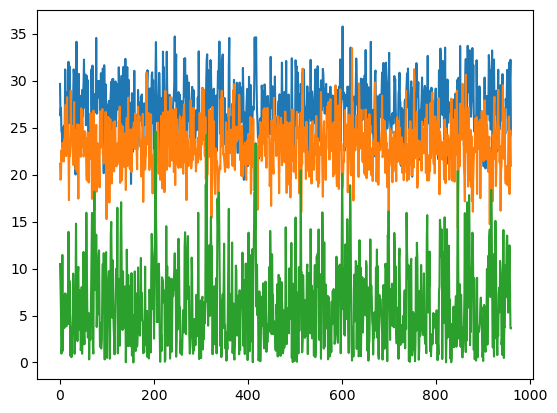

Mean s1: 26.993039430367435, Mean s2: 23.002954035393078


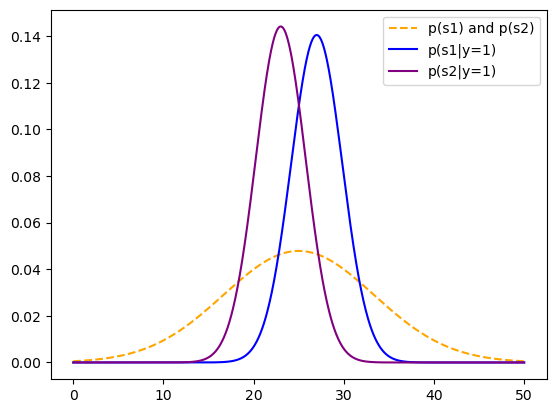

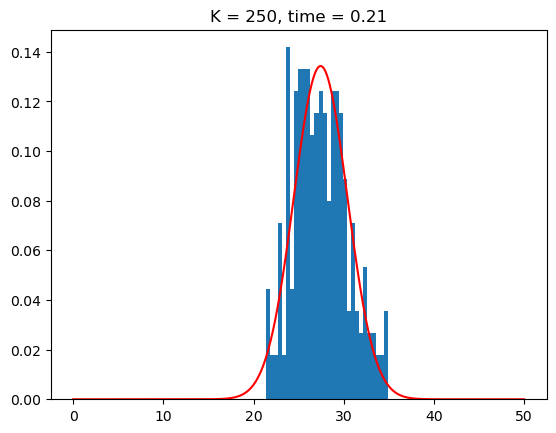

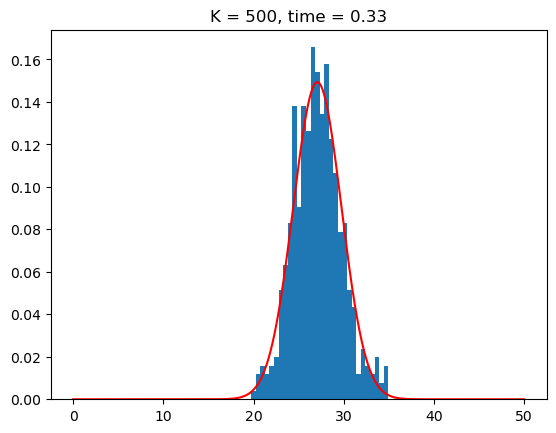

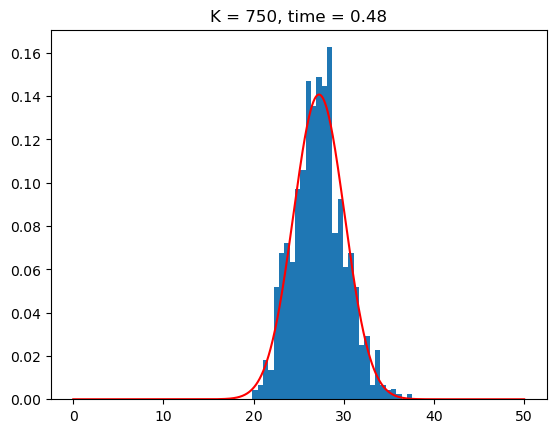

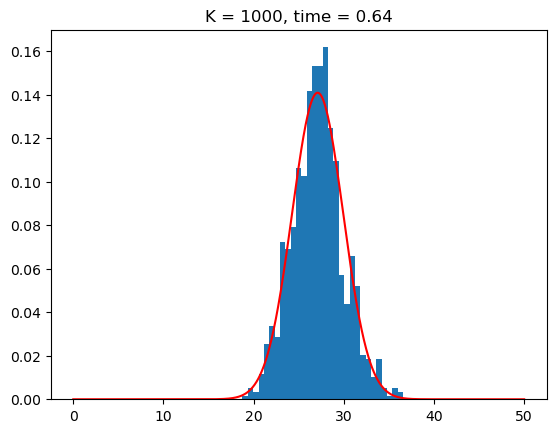

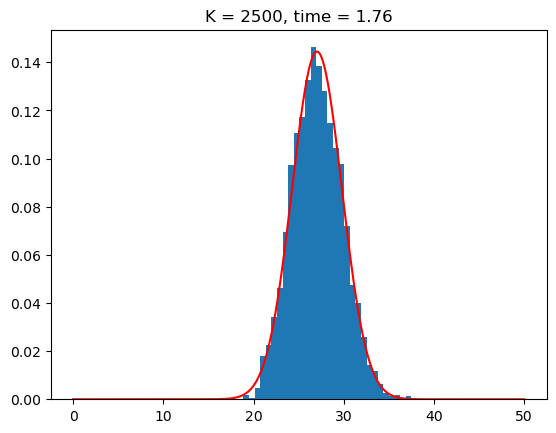

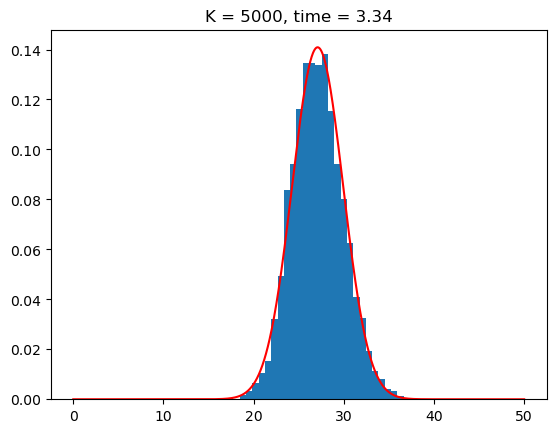

In [41]:
# Q.4 Gibbs sampler, one case where y = 1


# Same hyperparameters for p(s1) and p(s2)
# Default hyperparameter values are from "trueskill.org"

m_s1 = 25
m_s2 = 25
mu_s = np.array([m_s1, m_s2])

var_s1 = 25/3
var_s2 = 25/3
covar_s = np.array([[var_s1, 0], [0, var_s2]])
covar_ts = 5
t0 = 3

K = 1000

# Q.4 a) Burn in = 40
burn_in = 40

s1, s2, t = gibbs(K, mu_s, covar_s, covar_ts, t0, burn_in, 1)


# plot the result
kx = np.linspace(0, K-burn_in,K-burn_in)
plt.plot(kx, s1)
plt.plot(kx, s2)
plt.plot(kx, t)
plt.show()
print(f'Mean s1: {np.mean(s1)}, Mean s2: {np.mean(s2)}')



# Q.4 b) and d) They look good. p(s1) have an increased mean while the opposite happened to p(s2), this is because
# the initial condition was that y=1, player 1 won, thus that players skill level must increase more than s2.
xx = np.linspace(0, 50, 1000)    
trueskillGaussDist(xx ,s1, s2)

# Q.4 c) k= 750 was choosen because most of the sample values were in the Gaussian distribution and still had
# a good computational time, increasing the k to 1000 didn't make an enough of a difference in accuracy to justify the
# increase int computational time.
sss(Klist, mu_s, covar_s, covar_ts, 10, burn_in)

In [90]:
df = pd.read_csv("SerieA.csv")
K = 700
burn_in = 40



def assume_density(df, shuffle=False):
    
    df, clublist = dataPreprocesser(df)
    
    if shuffle == True:
        df = df.sample(frac=1, random_state=np.random.RandomState())

    for i, row in df.iterrows():
 
        m_s1 = float(clublist.loc[clublist["club"] == row["team1"],"mean"])
        m_s2 = float(clublist.loc[clublist["club"] == row["team2"],"mean"])
        mu_s = np.array([m_s1, m_s2])  
        var_s1 = float(clublist.loc[clublist["club"] == row["team1"],"variance"])
        var_s2 = float(clublist.loc[clublist["club"] == row["team2"],"variance"])
        covar_s = np.array([[var_s1, 0], [0, var_s2]])
        covar_ts = 25/3
        t0 = 3


        s1, s2, t = gibbs(K, mu_s, covar_s, covar_ts, t0, burn_in, row["result"])
    
    
        clublist.loc[clublist["club"] == row["team1"],"mean"] = np.mean(s1)
        clublist.loc[clublist["club"] == row["team2"],"mean"] = np.mean(s2)
        clublist.loc[clublist["club"] == row["team1"],"variance"] = np.var(s1)
        clublist.loc[clublist["club"] == row["team2"],"variance"] = np.var(s2)
        if row["team1"] or row["team2"]  == "Juventus":
            print("Roma\n")
            print(clublist.loc[clublist["club"] == "Juventus"])
            
assume_density(df)

Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.28606  0.914766
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.51248  0.952404
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.51248  0.952404
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.51248  0.952404
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  25.5124

Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.024507  0.925546
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.253857  0.958457
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.253857  0.958457
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.382401  0.926653
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.382401  0.926653
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.382401  0.926653
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.382401  0.926653
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.517771  0.947175
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.517771  0.947175
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.517771  0.947175
Roma

       club  win  loss       mean  variance
7  Juventu

Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.461137  1.016117
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.461137  1.016117
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.461137  1.016117
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.461137  1.016117
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.461137  1.016117
Roma

       club  win  loss      mean  variance
7  Juventus   28     4  28.65757  0.897507
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.758041  0.953963
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.758041  0.953963
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.758041  0.953963
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  28.758041  0.953963
Roma

       club  win  loss       mean  variance
7  Juventus 

Roma

       club  win  loss      mean  variance
7  Juventus   28     4  27.59029  0.904676
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.103481  0.935095
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.103481  0.935095
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.103481  0.935095
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.103481  0.935095
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.103481  0.935095
Roma

       club  win  loss       mean  variance
7  Juventus   28     4  27.103481  0.935095


In [65]:
df.sample(frac=1, random_state=np.random.RandomState())

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2,result
219,2019-02-04,21:00,Cagliari,Atalanta,0,1,-1
115,2018-11-11,15:00,Roma,Sampdoria,4,1,1
45,2018-09-23,15:00,Chievo,Udinese,0,2,-1
180,2018-12-29,12:30,Juventus,Sampdoria,2,1,1
3,2018-08-19,20:30,Sassuolo,Inter,1,0,1
...,...,...,...,...,...,...,...
19,2018-09-01,18:00,Bologna,Inter,0,3,-1
233,2019-02-17,12:30,Spal,Fiorentina,1,4,-1
310,2019-04-13,18:00,Roma,Udinese,1,0,1
353,2019-05-12,12:30,Torino,Sassuolo,3,2,1


In [81]:
print(tabulate(clublist.sort_values(by="win", ascending=False), headers="keys", tablefmt="psql"))

+----+------------+-------+--------+---------+------------+
|    | club       |   win |   loss |    mean |   variance |
|----+------------+-------+--------+---------+------------|
|  7 | Juventus   |    28 |      4 | 25.715  |   0.991122 |
|  8 | Napoli     |    24 |      7 | 25.5805 |   0.978653 |
| 16 | Inter      |    20 |      9 | 24.9618 |   0.929457 |
|  6 | Atalanta   |    20 |      9 | 25.2134 |   0.969825 |
| 13 | Milan      |    19 |      8 | 25.0249 |   0.937016 |
| 18 | Roma       |    18 |      8 | 24.937  |   0.959358 |
|  1 | Lazio      |    17 |     13 | 24.4428 |   0.959135 |
|  2 | Torino     |    16 |      7 | 24.7156 |   0.995121 |
| 15 | Sampdoria  |    15 |     15 | 24.7501 |   0.922375 |
| 10 | Udinese    |    11 |     17 | 25.278  |   0.903436 |
|  5 | Bologna    |    11 |     16 | 24.3709 |   0.91429  |
|  9 | Spal       |    11 |     18 | 25.5859 |   0.946319 |
| 14 | Parma      |    10 |     17 | 24.4125 |   0.945564 |
| 19 | Cagliari   |    10 |     17 | 24.

In [29]:
float(clublist.loc[clublist["club"] == "Juventus", "mean"])

27.115450105221367